In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

plt.style.use("dark_background")

In [2]:
df = pd.read_csv('../train_cleaned.csv')
df

,Gender,Balance,NumOfProducts,IsActiveMember,Geography_France,Geography_Germany,Geography_Spain,Age_bin,Exited
0,0,0.000000,2,0.000000,1,0,0,1,0
1,0,0.000000,2,1.000000,1,0,0,1,0
2,0,0.000000,2,0.000000,1,0,0,3,0
3,0,148882.540000,1,1.000000,1,0,0,1,0
4,0,0.000000,2,1.000000,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...
260221,1,0.000000,1,0.000000,1,0,0,3,1
260222,0,0.000000,1,1.000000,0,0,1,4,1
260223,1,0.000000,1,1.000000,0,0,1,2,1
260224,0,100156.868244,1,0.088564,0,0,0,3,1


In [3]:
class LinearClassifier:
    """
    Класс линейного классификатора с поддержкой регуляризации, момента и различных методов инициализации весов.

    Параметры:
        regularization (float): Коэффициент регуляризации.
        weight_mode (str): Метод инициализации весов.
        momentum (float): Коэффициент момента.
        max_iter (int): Максимальное количество итераций.
        smooth_factor (float): Коэффициент сглаживания для потерь.
    """

    def __init__(self, regularization=0.01, weight_mode="random", momentum=0.9, max_iter=100, smooth_factor=0.5):
        # Инициализация параметров класса
        self.regularization = regularization
        self.weight_mode = weight_mode
        self.momentum = momentum
        self.max_iter = max_iter
        self.smooth_factor = smooth_factor
        self.weights = None
        self.velocity = None  # момент для обновления весов
        self.loss_history = []

    def _initialize_weights(self, X, y, retries=10):
        """
        Инициализирует веса в зависимости от выбранного метода.

        Параметры:
            X (numpy.ndarray): Матрица признаков.
            y (numpy.ndarray): Вектор меток.
            retries (int): Количество попыток для метода "multistart".

        Возвращает:
            numpy.ndarray: Инициализированные веса.
        """
        n_features = X.shape[1]  # количество признаков

        if self.weight_mode == "random":
            scale = 1 / (2 * n_features)
            return np.random.uniform(-scale, scale, n_features)  # генерация случайных весов

        elif self.weight_mode == "correlation":
            # инициализация весов на основе корреляции с метками
            weights = np.zeros(n_features)
            for i in range(n_features):
                weights[i] = np.dot(y, X[:, i]) / np.dot(X[:, i], X[:, i])  # вычисление весов на основе корреляции
            return weights

        elif self.weight_mode == "multistart":
            # инициализация весов методом многократного старта
            best_loss = float('inf')
            best_weights = None
            for _ in range(retries):
                trial_weights = np.random.uniform(-1 / (2 * n_features), 1 / (2 * n_features), n_features)  # генерация пробных весов
                trial_loss = self._compute_loss(X, y, trial_weights)  # вычисление потерь для пробных весов
                if trial_loss < best_loss:
                    best_loss = trial_loss
                    best_weights = trial_weights  # сохранение лучших весов
            return best_weights

    def _margin(self, X, y):
        """
        Вычисляет значения маржинов.

        Параметры:
            X (numpy.ndarray): Матрица признаков.
            y (numpy.ndarray): Вектор меток.

        Возвращает:
            numpy.ndarray: Маржинальные значения.
        """
        return y * np.dot(X, self.weights)  # значения маржинов

    def _compute_loss(self, X, y, weights):
        """
        Вычисляет значение функции потерь.

        Параметры:
            X (numpy.ndarray): Матрица признаков.
            y (numpy.ndarray): Вектор меток.
            weights (numpy.ndarray): Веса.

        Возвращает:
            float: Значение функции потерь.
        """
        predictions = np.dot(X, weights)  # предсказанные значения
        errors = y - predictions  # ошибки предсказаний
        return np.mean(errors**2) + self.regularization * np.sum(weights**2) / 2  # среднеквадратичная ошибка с регуляризацией

    def _compute_gradient(self, X, y):
        """
        Вычисляет градиент функции потерь.

        Параметры:
            X (numpy.ndarray): Матрица признаков.
            y (numpy.ndarray): Вектор меток.

        Возвращает:
            numpy.ndarray: Градиент функции потерь.
        """
        predictions = np.dot(X, self.weights)  # предсказанные значения
        errors = y - predictions  # ошибки предсказаний
        grad = -2 * np.dot(X.T, errors) / len(y)  # градиент без регуляризации
        grad += self.regularization * self.weights  # добавляем регуляризацию
        return grad

    def fit(self, X, y):
        """
        Обучение модели.

        Параметры:
            X (numpy.ndarray): Матрица признаков.
            y (numpy.ndarray): Вектор меток.
        """
        self.weights = self._initialize_weights(X, y)  # инициализация весов
        self.velocity = np.zeros_like(self.weights)  # инициализация момента
        smoothed_loss = self._compute_loss(X, y, self.weights)  # начальное значение функции потерь

        for iteration in range(self.max_iter):
            grad = self._compute_gradient(X, y)  # вычисление градиента
            self.velocity = self.momentum * self.velocity + (1 - self.momentum) * grad  # обновление момента
            self.weights -= self.velocity  # обновление весов

            current_loss = self._compute_loss(X, y, self.weights)  # текущее значение функции потерь
            smoothed_loss = self.smooth_factor * current_loss + (1 - self.smooth_factor) * smoothed_loss  # сглаживание потерь
            self.loss_history.append(smoothed_loss)

            if (iteration + 1) % 1000 == 0:
                print(f"Iteration {iteration + 1}/{self.max_iter}, Loss: {smoothed_loss:.4f}")

    def predict(self, X):
        """
        Предсказывание метки.

        Параметры:
            X (numpy.ndarray): Матрица признаков.

        Возвращает:
            numpy.ndarray: Предсказанные метки.
        """
        return np.sign(np.dot(X, self.weights))  # предсказанные метки

    def evaluate(self, X, y):
        """
        Оценка модели.

        Параметры:
            X (numpy.ndarray): Матрица признаков.
            y (numpy.ndarray): Вектор меток.

        Возвращает:
            tuple: Метрики оценки (accuracy, precision, recall, f1).
        """
        predictions = self.predict(X)  # предсказанные метки

        accuracy = accuracy_score(y, predictions)
        precision = precision_score(y, predictions)
        recall = recall_score(y, predictions)
        f1 = f1_score(y, predictions)

        print(f"\nEvaluation Metrics:")
        print(f"  Accuracy:  {accuracy:.4f}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall:    {recall:.4f}")
        print(f"  F1-Score:  {f1:.4f}")

        return accuracy, precision, recall, f1

In [4]:
def visualize_sorted_margins(X, y, model, title="Title"):
    
    if hasattr(model, "_margin"):
        margins = model._margin(X, y)
    else:
        margins = y * np.dot(X, model.coef_.T).flatten()

    margins_sorted = np.sort(margins)

    plt.figure(figsize=(12, 6))
    plt.plot(margins_sorted, color="#fffde1", linestyle="-", linewidth=1.5, label="Sorted Margins")
    plt.axhline(0, color="#ff7f50", linestyle="--", linewidth=1.5, label="Decision Boundary")

    plt.fill_between(
        range(len(margins_sorted)),
        margins_sorted,
        0,
        where=(margins_sorted < 0),
        color="#fb3569",
        alpha=0.6,
        label="Incorrect Classification"
    )

    plt.fill_between(
        range(len(margins_sorted)),
        margins_sorted,
        0,
        where=(margins_sorted > 0),
        color="#008080",
        alpha=0.6,
        label="Correct Classification"
    )

    plt.title(title)
    plt.xlabel("Index")
    plt.ylabel("Margin")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

In [5]:
X = df.drop(columns=['Exited']).values
y = df['Exited'].values
y = np.where(y == 0, -1, 1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Iteration 1000/10000, Loss: 0.9789
Iteration 2000/10000, Loss: 0.9479
Iteration 3000/10000, Loss: 0.9199
Iteration 4000/10000, Loss: 0.8946
Iteration 5000/10000, Loss: 0.8717
Iteration 6000/10000, Loss: 0.8509
Iteration 7000/10000, Loss: 0.8321
Iteration 8000/10000, Loss: 0.8152
Iteration 9000/10000, Loss: 0.7998
Iteration 10000/10000, Loss: 0.7859
CPU times: user 2min 56s, sys: 3min 31s, total: 6min 28s
Wall time: 35.2 s

Evaluation Metrics:
  Accuracy:  0.7691
  Precision: 0.7846
  Recall:    0.7418
  F1-Score:  0.7626


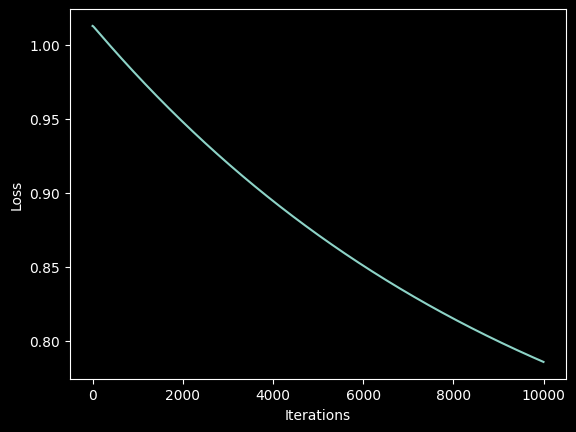

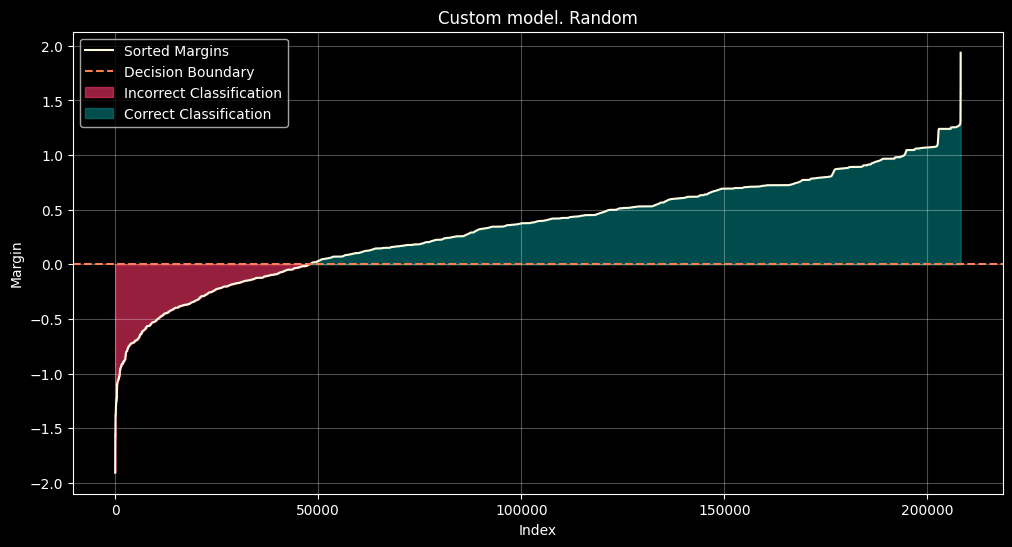

In [7]:
model = LinearClassifier(
    regularization=0.0001,
    weight_mode="random",
    momentum=0.95,
    max_iter=10000,
    smooth_factor=0.0001
)

%time model.fit(X_train_scaled, y_train)
model.evaluate(X_test_scaled, y_test)

plt.plot(model.loss_history)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()

visualize_sorted_margins(X_train_scaled, y_train, model, title="Custom model. Random")

Iteration 1000/10000, Loss: 0.7487
Iteration 2000/10000, Loss: 0.7396
Iteration 3000/10000, Loss: 0.7314
Iteration 4000/10000, Loss: 0.7240
Iteration 5000/10000, Loss: 0.7173
Iteration 6000/10000, Loss: 0.7113
Iteration 7000/10000, Loss: 0.7058
Iteration 8000/10000, Loss: 0.7008
Iteration 9000/10000, Loss: 0.6963
Iteration 10000/10000, Loss: 0.6923
CPU times: user 2min 58s, sys: 3min 27s, total: 6min 25s
Wall time: 34.6 s

Evaluation Metrics:
  Accuracy:  0.7691
  Precision: 0.7846
  Recall:    0.7418
  F1-Score:  0.7626


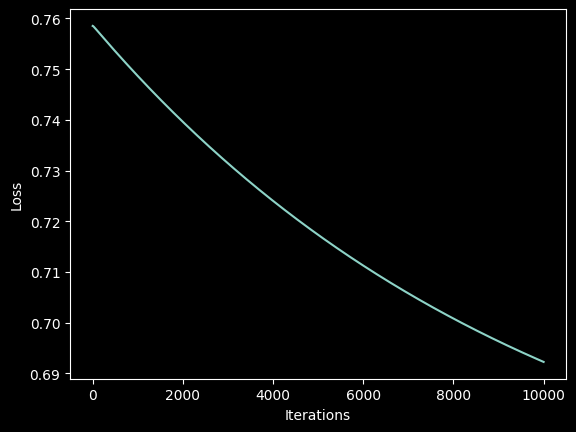

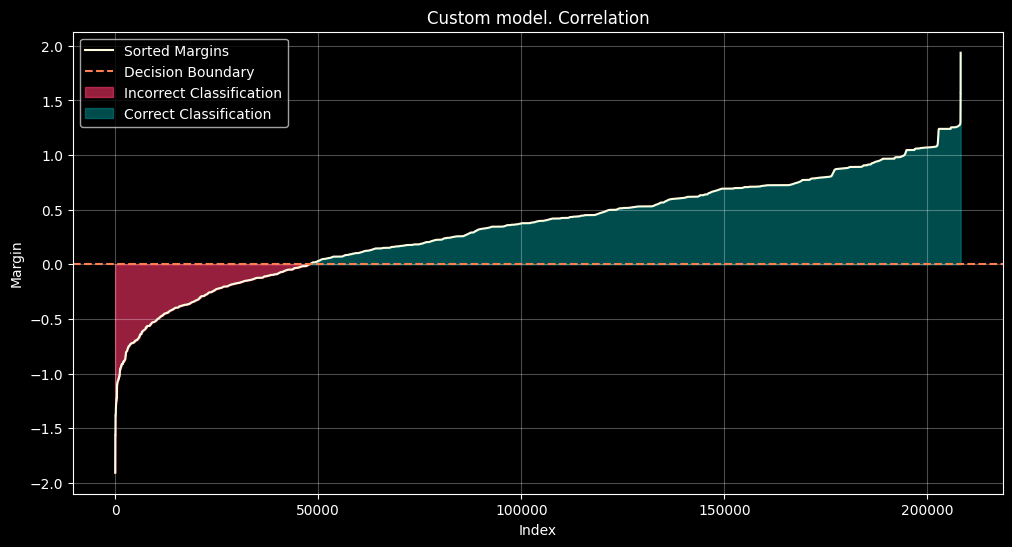

In [8]:
model = LinearClassifier(
    regularization=0.0001,
    weight_mode="correlation",
    momentum=0.95,
    max_iter=10000,
    smooth_factor=0.0001
)

%time model.fit(X_train_scaled, y_train)
model.evaluate(X_test_scaled, y_test)

plt.plot(model.loss_history)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()

visualize_sorted_margins(X_train_scaled, y_train, model, title="Custom model. Correlation")

Iteration 1000/10000, Loss: 0.9517
Iteration 2000/10000, Loss: 0.9233
Iteration 3000/10000, Loss: 0.8976
Iteration 4000/10000, Loss: 0.8744
Iteration 5000/10000, Loss: 0.8534
Iteration 6000/10000, Loss: 0.8344
Iteration 7000/10000, Loss: 0.8172
Iteration 8000/10000, Loss: 0.8016
Iteration 9000/10000, Loss: 0.7876
Iteration 10000/10000, Loss: 0.7748
CPU times: user 2min 57s, sys: 3min 17s, total: 6min 14s
Wall time: 33.5 s

Evaluation Metrics:
  Accuracy:  0.7691
  Precision: 0.7846
  Recall:    0.7418
  F1-Score:  0.7626


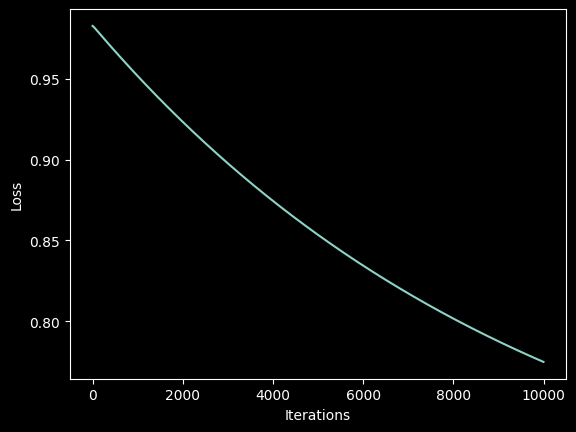

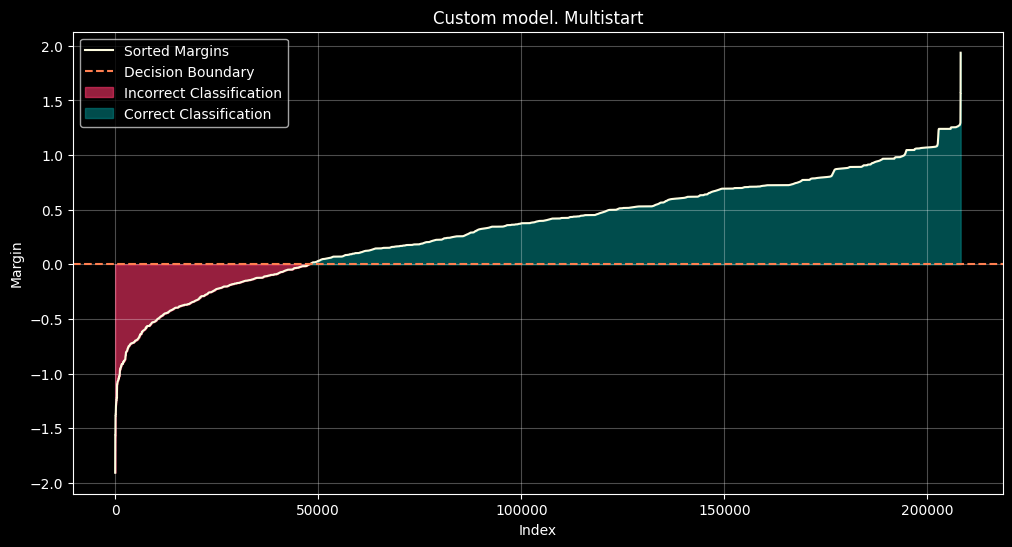

In [9]:
model = LinearClassifier(
    regularization=0.0001,
    weight_mode="multistart",
    momentum=0.95,
    max_iter=10000,
    smooth_factor=0.0001
)

%time model.fit(X_train_scaled, y_train)
model.evaluate(X_test_scaled, y_test)

plt.plot(model.loss_history)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()

visualize_sorted_margins(X_train_scaled, y_train, model, title="Custom model. Multistart")

CPU times: user 1.32 s, sys: 3.92 s, total: 5.24 s
Wall time: 488 ms
Sklearn Model Metrics:
Accuracy: 0.7927
Precision: 0.8137
Recall: 0.7594
F1-Score: 0.7856


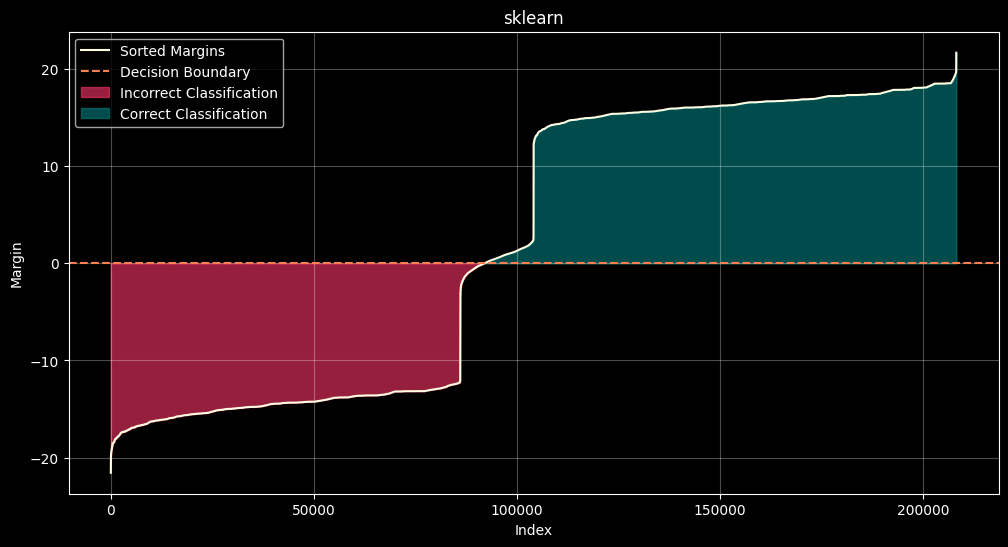

In [10]:
sklearn_model = LogisticRegression(
    penalty='l2',
    C=10000,
    solver='lbfgs',
    max_iter=10000,
    random_state=42
)
%time sklearn_model.fit(X_train_scaled, y_train)

y_pred_sklearn = sklearn_model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred_sklearn)
precision = precision_score(y_test, y_pred_sklearn)
recall = recall_score(y_test, y_pred_sklearn)
f1 = f1_score(y_test, y_pred_sklearn)

print(f"\nSklearn Model Metrics:")
print(f"  Accuracy:  {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall:.4f}")
print(f"  F1-Score:  {f1:.4f}")

visualize_sorted_margins(X_train_scaled, y_train, sklearn_model, title="sklearn")